## Introduction
Natural language processing is useful for performing tasks like text classification which in this case involves the assignment of text to predefined categories. The dataset utilised for this project is the AG News dataset, a widely used benchmark in research, containing news titles and descriptions categorised into four classes. It consists of a collection of news articles, each categorised into one of four predefined classes: World, Sports, Business, and Technology. 

Each instance in the dataset contains a brief title summarising the news article, alongside a corresponding category label. The dataset includes 120,000 examples in total, with 30,000 examples per class used for training and 7,600 examples split evenly across the classes for testing. Strengths of the dataset come in its simplicity, and it features a  balanced class distribution, and the titles are relevant to real-world scenarios. The category labels are encoded as numerical values: World as 0, Sports as 1, Business as 2, and Technology as 3.
The project aims to classify the titles of news articles into 4 categories of World, Sports, Business, Technology. This classification task presents an opportunity to apply various machine learning and natural language processing techniques and assess their performance to the dataset.

In [31]:
from datasets import load_dataset

ds = load_dataset("wangrongsheng/ag_news")

In [32]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


In [33]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/wangrongsheng/ag_news/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/wangrongsheng/ag_news/" + splits["test"])

In [35]:
# print the first 5 rows of the dataframe
df.head(5)

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [36]:
from collections import Counter
cnt = Counter()
for text in df['text'].values:
    for word in text.split():
        cnt[word] += 1
cnt.most_common(10)

[('the', 177529),
 ('to', 117605),
 ('a', 98112),
 ('of', 97395),
 ('in', 92055),
 ('and', 68046),
 ('on', 55156),
 ('for', 48430),
 ('-', 39105),
 ('#39;s', 30928)]

<!-- DATA DESCRIPTION -->

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    120000 non-null  object
 1   label   120000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


<!-- No need for type conversion as the data is already in the required format. -->

In [38]:
# check for missing values
df.isnull().sum()

text     0
label    0
dtype: int64

In [39]:
# crosscheck by checking for empty strings
(df == '').sum()

text     0
label    0
dtype: int64

In [40]:
df['label'].value_counts()

label
2    30000
3    30000
1    30000
0    30000
Name: count, dtype: int64

In [41]:
# get mean length of text
print(df['text'].str.split().apply(len).mean())

37.84745


<!-- The data is evenly distributed between the classes. This is a positive point as the model will not be biased towards any class. -->

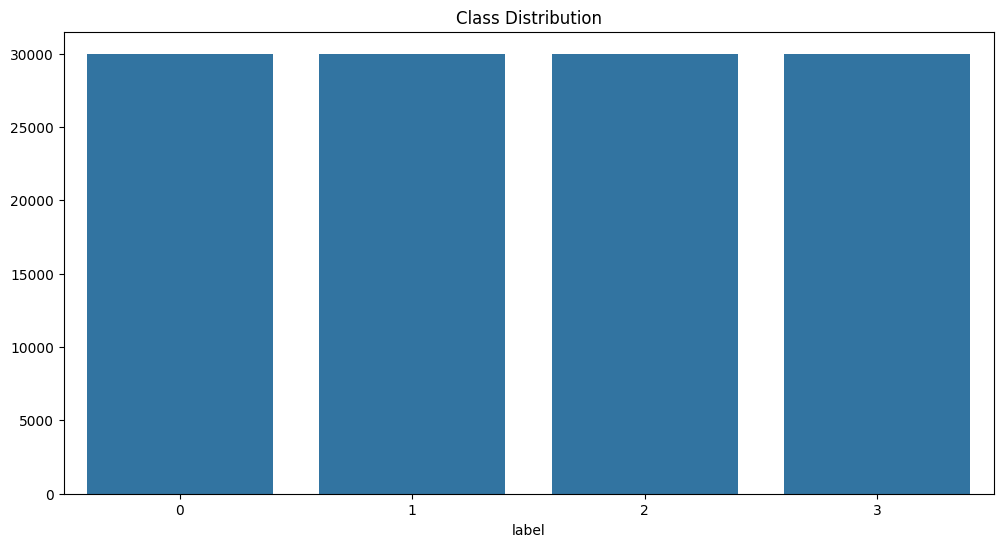

In [42]:
class_distribution = df['label'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Class Distribution')

plt.show()

## Representation Learning
The representation learning approach used in this project involves converting the text in the title column into numerical representations that capture the meaning and relationships between words. To achieve this, GloVe embeddings were used as the main method. GloVe creates a dense vector for each word based on how often it appears alongside other words in large amounts of text. This helps the model understand how words are related to each other.

In cases where GloVe did not have a vector for a particular word, FastText embeddings were used instead. Unlike GloVe, FastText breaks words into smaller parts, which means it can create representations even for words it has never seen before by using patterns within the word itself. This fallback ensures that all words in the dataset, even rare ones, are represented.

By combining GloVe and FastText, this approach makes sure that most of the words in the text are covered. If GloVe and FastText are still unable to capture the words, a dense vector full of 0’s are created for that word.* This allows the model to understand both the overall meaning of words which helps improve the accuracy of the classification task.

In [43]:
# import libraries for text preprocessing
import re
import string
import numpy as np
import nltk
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

<!-- Lematization over Stemming: Lemmatization is preferred over stemming as it converts the word into its root form based on the dictionary. This helps in maintaining the context of the sentence especially in the case of this dataset where the text is news headlines. Needing the context of the sentence is important to understand the news headline.  -->

In [44]:
nltk.download("punkt", quiet=True)
nltk.download("punkt_tab", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)

True

In [45]:
def text_preprocess(text):
    """
    Preprocesses the input text by applying:
    - Lowercasing
    - Removing numbers and special characters
    - Tokenizing and lemmatizing
    - Removing stopwords and short words
    
    Args:
        text (str): The input text string.

    Returns:
        str: The cleaned and processed text.
    """
    # Lowercase the text
    text = text.lower()
    # Remove numbers, special characters, and hyphens; replace with spaces
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove short words (1-2 characters)
    text = re.sub(r'\b\w{1,2}\b', '', text).strip()
    
    # Tokenize and lemmatize, excluding stopwords
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Join tokens back into a single string
    return ' '.join(processed_tokens)

In [46]:
# batching to speed up the process
def batch_preprocess(data, batch_size=1000):
    """
    Preprocess a large dataset in batches.

    Parameters:
        data (iterable): List or Series of text data.
        batch_size (int): Size of each batch for processing.

    Returns:
        List of preprocessed texts.
    """
    preprocessed_data = []
    num_batches = len(data) // batch_size + 1
    
    for i in tqdm(range(num_batches), desc="Processing Batches"):
        batch = data[i * batch_size:(i + 1) * batch_size]
        preprocessed_batch = [text_preprocess(text) for text in batch]
        preprocessed_data.extend(preprocessed_batch)
    
    return preprocessed_data

In [47]:
X_train = batch_preprocess(df['text'])
y_train = df['label']

Processing Batches: 100%|██████████| 121/121 [01:25<00:00,  1.41it/s]


In [48]:
X_test = batch_preprocess(df_test['text'])
y_test = df_test['label']

Processing Batches: 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


In [49]:
# print before and after preprocessing
print("Before Preprocessing:", df['text'][0])
print("After Preprocessing:", X_train[0])


Before Preprocessing: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
After Preprocessing: wall bear claw back black reuters reuters shortsellers wall street dwindlingband ultracynics seeing green


In [50]:
# count most common after preprocessing
cnt = Counter()
for text in X_train:
    for word in text.split():
        cnt[word] += 1

cnt.most_common(10)

[('new', 21223),
 ('said', 19995),
 ('reuters', 17243),
 ('year', 11520),
 ('company', 10052),
 ('first', 9048),
 ('two', 8926),
 ('world', 8637),
 ('say', 7671),
 ('game', 7552)]

In [51]:
# find first 5 lines where top 10 words are present
top_10_words = [word for word, _ in cnt.most_common(10)]
lines_with_top_10_words = []

for line in X_train:
    if any(word in line for word in top_10_words):
        lines_with_top_10_words.append(line)
    if len(lines_with_top_10_words) == 5:
        break

lines_with_top_10_words

['wall bear claw back black reuters reuters shortsellers wall street dwindlingband ultracynics seeing green',
 'carlyle look toward commercial aerospace reuters reuters private investment firm carlyle groupwhich reputation making welltimed occasionallycontroversial play defense industry quietly placedits bet another part market',
 'oil economy cloud stock outlook reuters reuters soaring crude price plus worriesabout economy outlook earnings expected tohang stock market next week depth thesummer doldrums',
 'iraq halt oil export main southern pipeline reuters reuters authority halted oil exportflows main pipeline southern iraq afterintelligence showed rebel militia could strikeinfrastructure oil official said saturday',
 'oil price soar alltime record posing new menace economy afp afp tearaway world oil price toppling record straining wallet present new economic menace barely three month presidential election']

In [52]:
import gensim.downloader as api

In [53]:
if 'glove_model' not in globals():
    glove_model = api.load("glove-wiki-gigaword-100")

In [54]:
if 'fasttext_model' not in globals():
    fasttext_model = api.load("fasttext-wiki-news-subwords-300")

In [55]:
def text_to_glove(text, glove_model, fasttext_model, embedding_dim=100):
    """
    Convert text to GloVe/FastText embeddings with fallback to zeros for OOV tokens.
    """
    tokens = word_tokenize(text.lower())
    vectors = []

    for token in tokens:
        if token in glove_model:
            vectors.append(glove_model[token])  # Get the GloVe vector
        elif token in fasttext_model:
            vectors.append(fasttext_model[token][:embedding_dim])  # Get the FastText vector
        else:
            vectors.append(np.zeros(embedding_dim))  # If not found, use zeros

    # Pool vectors to represent the entire text (mean pooling)
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(embedding_dim)


In [56]:
X_train_glove = np.array([text_to_glove(text, glove_model, fasttext_model) for text in X_train])

In [57]:
X_test_glove = np.array([text_to_glove(text, glove_model, fasttext_model) for text in X_test])

In [58]:
print("Shape of the GloVe vectors:", X_train_glove.shape)

Shape of the GloVe vectors: (120000, 100)


## Algorithms
This project applies two algorithms to classify news article titles from the AG News dataset into four categories: World, Sports, Business, and Technology. The machine learning algorithms used are a multi-layer perceptron (MLP) and a random forest classifier. These two methods represent different approaches to classification, and the aim is to compare their effectiveness for this task, which involves short and concise text data.

### Multi-Layer Perceptron (MLP)
A multi-layer perceptron is a type of model that processes data through several layers to learn patterns and relationships. It is designed to handle tasks where the data is complex or requires identifying non-linear relationships. In this project, the MLP uses word embeddings, which are numerical representations of words created using GloVe and FastText. 
The MLP consists of three parts:
+ **Input Layer**: This is where the word embeddings for the news titles are fed into the model. Each title is represented as a numerical vector, combining the embeddings for its words.
+ **Hidden Layers**: These layers process the input data, applying transformations that allow the model to recognise patterns. Each layer uses weights and biases to determine how strongly different parts of the data are connected.
+ **Output Layer**: This layer produces the final predictions. It has four outputs, one for each category, and chooses the category with the highest score as the predicted label.
The MLP is trained using a process that compares its predictions to the correct answers and adjusts the connections within the model to improve accuracy. By repeatedly doing this, the MLP learns how to classify titles based on their word representations. This approach is particularly effective for this project because it uses word embeddings that capture the relationships between words in a meaningful way.

### Random Forest Classifier
Random Forest Classifier
The Random Forest Classifier is a method that uses multiple decision trees to make predictions. Each tree splits the data into groups based on specific features, and the overall prediction is made by combining the results from all the trees. This method is straightforward and works well with structured data.

This method has the many advantages. Using K-Folds cross-validation with the Random Forest Classifier leads to more dependable predictions. It ensures that the model learns well from the training data while also performing consistently on new data to reduce overfitting. This combination is particularly effective for structured datasets, where the decision trees can take advantage of the underlying patterns, resulting in better accuracy overall.

K-Folds cross-validation is a technique that can improve the evaluation of the Random Forest Classifier. It splits the dataset into K folds. The model is trained on K-1 of these folds and tested on the remaining fold. This process is repeated K times, with each fold being used as the test set once. The final performance metric is usually the average of the results from all iterations.

In [59]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

In [60]:
# Initialize the MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=100, early_stopping=True, activation='relu', solver='adam') # adam solver is used for large datasets to avoid overfitting
mlp.fit(X_train_glove, y_train)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(256, 128), max_iter=100)

In [61]:
y_pred = mlp.predict(X_test_glove)

In [62]:
relu_report = classification_report(y_test, y_pred)
print(relu_report)

              precision    recall  f1-score   support

           0       0.94      0.89      0.91      1900
           1       0.94      0.99      0.96      1900
           2       0.86      0.87      0.87      1900
           3       0.88      0.88      0.88      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



In [63]:
# mlp with different activation function
mlp_tanh = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=100, early_stopping=True, activation='tanh', solver='adam')
mlp_tanh.fit(X_train_glove, y_train)

MLPClassifier(activation='tanh', early_stopping=True,
              hidden_layer_sizes=(256, 128), max_iter=100)

In [64]:
y_pred_tanh = mlp_tanh.predict(X_test_glove)

In [65]:
tanh_report = classification_report(y_test, y_pred_tanh)
print(tanh_report)

              precision    recall  f1-score   support

           0       0.92      0.89      0.90      1900
           1       0.95      0.98      0.96      1900
           2       0.85      0.87      0.86      1900
           3       0.88      0.87      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600



tanh activation function increases the precision in 0 (world news) and 1 (sports), while relu activation function increases the precision in 2 (business) and 3 (science and technology). This could be due to tanh being able to capture the non-linear relationships better than relu and with the nature of news headlines, it is important to capture the non-linear relationships.

In [66]:
from sklearn.utils import parallel_backend

# mlp with activation function
with parallel_backend('threading', n_jobs=-1):
    mlp_logistic = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=100, early_stopping=True, activation='logistic', solver='adam')
    mlp_logistic.fit(X_train_glove, y_train)

c:\Users\User\Documents\CMM307-PRINCESS-UKANWA\cmmvenv\Lib\site-packages\sklearn\utils\deprecation.py:66: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)


In [67]:
y_pred_logistic = mlp_logistic.predict(X_test_glove)

In [68]:
logistic_report = classification_report(y_test, y_pred_logistic)
print(logistic_report)

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1900
           1       0.95      0.98      0.96      1900
           2       0.86      0.87      0.87      1900
           3       0.88      0.88      0.88      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600



In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [70]:
def run_model(X, y, model, kf):
    accuracies = []
    reports = []

    # loop through each fold
    for train_index, val_index in tqdm(
        kf.split(X, y), total=kf.get_n_splits(), desc="Progress"
    ):
        # split
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # fit the model
        model.fit(X_train, y_train)

        # predict
        y_pred = model.predict(X_val)

        # get accuracy
        accuracy = accuracy_score(y_val, y_pred)
        accuracies.append(accuracy)

        # get classification report
        report = classification_report(y_val, y_pred, output_dict=True)
        reports.append(report)

    # Aggregate the results
    avg_report = {
        metric: np.mean([report['weighted avg'][metric] for report in reports])
        for metric in ["precision", "recall", "f1-score"]
    }

    return {
        "accuracies" : accuracies,
        "avg_report": avg_report
    }

In [71]:
rf_model = RandomForestClassifier(
    n_estimators=50, 
    max_depth=20,
    max_samples=.8,
    )

In [72]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)

# rf_results = run_model(X_train_glove, y_train, rf_model, kfold)

In [73]:
# print(f"Accuracies: {rf_results['accuracies']}")
# print(f"Average Report: {rf_results['avg_report']}")

In [74]:
from sklearn.utils import parallel_backend


def run_model_with_backend(X, y, model, kf):
    accuracies = []
    reports = []

    with parallel_backend("threading", n_jobs=-1):  # Use threading or multiprocessing
        for train_index, val_index in tqdm(
            kf.split(X, y), total=kf.get_n_splits(), desc="Progress"
        ):
            # split
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            # fit the model
            model.fit(X_train, y_train)

            # predict
            y_pred = model.predict(X_val)

            # get accuracy
            accuracy = accuracy_score(y_val, y_pred)
            accuracies.append(accuracy)

            # get classification report
            report = classification_report(y_val, y_pred, output_dict=True)
            reports.append(report)

    # Aggregate the results
    avg_report = {
        metric: np.mean([report["weighted avg"][metric] for report in reports])
        for metric in ["precision", "recall", "f1-score"]
    }

    return {"accuracies": accuracies, "avg_report": avg_report}

In [75]:
rf_results_backend = run_model_with_backend(X_train_glove, y_train, rf_model, kfold)

c:\Users\User\Documents\CMM307-PRINCESS-UKANWA\cmmvenv\Lib\site-packages\sklearn\utils\deprecation.py:66: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)
Progress: 100%|██████████| 5/5 [02:02<00:00, 24.55s/it]


In [76]:
print(f"Accuracies: {rf_results_backend['accuracies']}")
print(f"Mean Accuracy: {np.mean(rf_results_backend['accuracies'])}")
print(f"Average Report: {rf_results_backend['avg_report']}")

Accuracies: [0.88625, 0.8840416666666666, 0.8857083333333333, 0.8837083333333333, 0.8865833333333333]
Mean Accuracy: 0.8852583333333331
Average Report: {'precision': 0.8853831604521549, 'recall': 0.8852583333333331, 'f1-score': 0.8851323346588018}


In [77]:
# from sklearn.model_selection import GridSearchCV, ParameterGrid

# param_grid = {
#     "n_estimators": [50, 100],
#     "max_depth": [None,10, 20],
#     "max_samples": [0.8, 1.0],
#     "min_samples_split": [2, 5],
#     "min_samples_leaf": [1, 2],
#     "max_features": ["auto", "sqrt", "log2", None], 
# }

In [78]:
# best_score = 0
# best_params = {}
# results = []

# for params in tqdm(list(ParameterGrid(param_grid)), desc="Grid Search"):
#     # Initialize the model
#     rf_model = RandomForestClassifier(
#         n_estimators=params["n_estimators"],
#         max_depth=params["max_depth"],
#         max_samples=params["max_samples"],
#         # min_samples_split=params["min_samples_split"],
#         # min_samples_leaf=params["min_samples_leaf"],
#         # max_features=params["max_features"],
#         n_jobs=-1, # Use all available cores
#     )

#     # Run the model
#     rf_results = run_model_with_backend(X_train_glove, y_train, rf_model, kfold)

#     # Save the results
#     mean_accuracy = np.mean(rf_results["accuracies"])
#     results.append({"params": params, "mean_accuracy": mean_accuracy})

#     # Update the best score and parameters
#     if mean_accuracy > best_score:
#         best_score = mean_accuracy
#         best_params = params    


In [79]:
# print(f"Best Score: {best_score}")
# print(f"Best Parameters: {best_params}")

## Evaluation
The evaluation process compares the performance of the multi-layer perceptron (MLP) and random forest classifier in classifying news article titles from the AG News dataset into the four categories. Both algorithms were assessed using the test dataset, and their performances were measured using the following metrics: accuracy, precision, recall, and F1-score.

The random forest classifier achieved an average accuracy of 88.% across multiple runs, with individual accuracies ranging from 88.2% to 88.85%. The average precision, recall, and F1-score were approximately 88.5%, indicating that the model was consistent in predicting all four categories.

The MLP demonstrated an accuracy of 90%, outperforming the random forest. It achieved a macro-average precision, recall, and F1-score of 90%. The slightly lower performance for ‘business’ may reflect the overlap of certain terms with other categories, making classification more challenging.

Overall, MLP’s ability to leverage pre-trained word embeddings (GloVe and FastText) allowed it to capture semantic relationships between words, contributing to its enhanced performance. In contrast, the random forest’s reliance on independent word importance limited its ability to model context. This highlights the strength of using representation learning in tasks that require understanding the meaning of text.

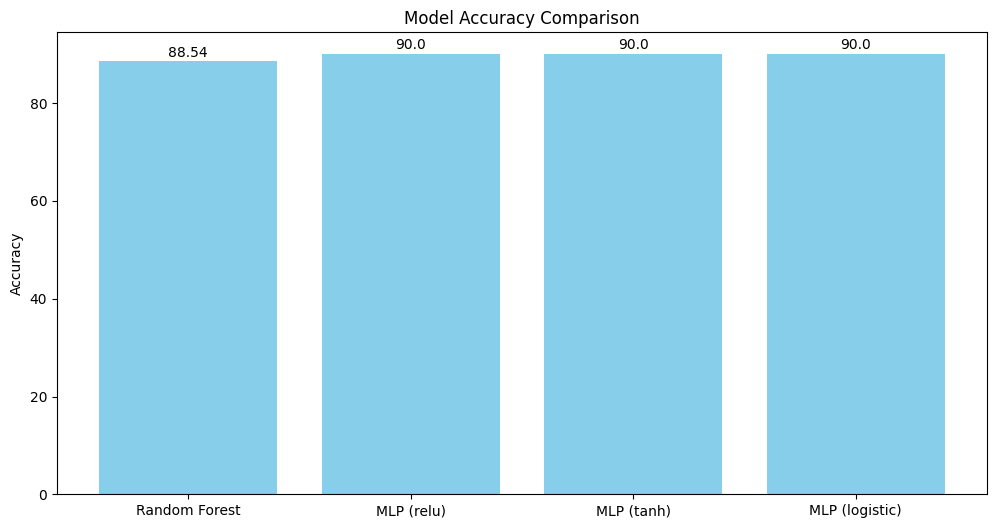

In [80]:
models = ['Random Forest', 'MLP (relu)', 'MLP (tanh)', 'MLP (logistic)']
accuracies = [round(rf_results_backend['avg_report']['precision'] * 100, 2), 90.0, 90.0, 90.0]

plt.figure(figsize=(12, 6))
plt.bar(models, accuracies, color='skyblue')
plt.xticks(models)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
for i, v in enumerate(accuracies):
    plt.text(i, v + 1, str(v), ha='center')
plt.show()


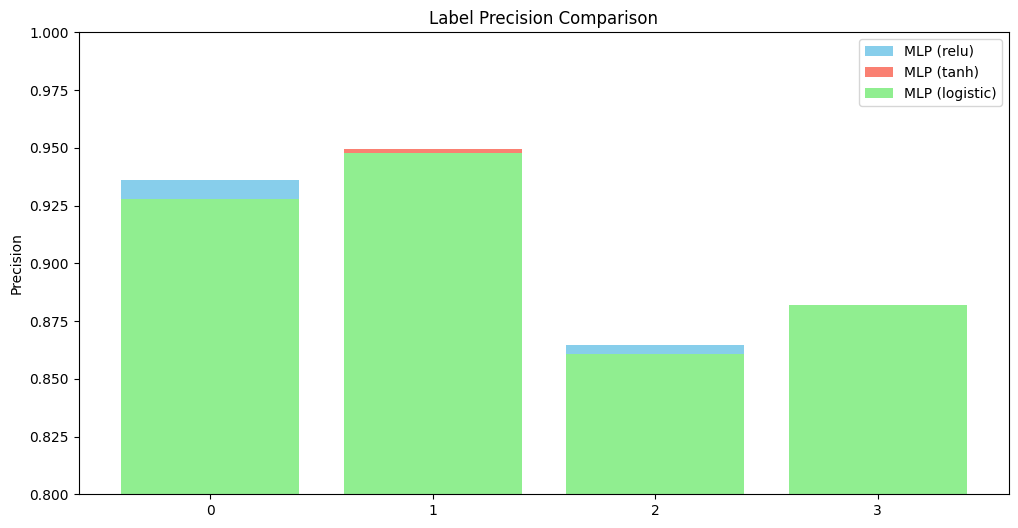

In [81]:
# compare label precisions (0-3) for each MLP variant
labels = ['0', '1', '2', '3']


def get_label_precision(y_true, y_pred, label):
    return classification_report(y_true, y_pred, output_dict=True)[label]['precision']


mlp_relu_label_precisions = [get_label_precision(y_test, y_pred, label) for label in labels]

mlp_tanh_label_precisions = [get_label_precision(y_test, y_pred_tanh, label) for label in labels]

mlp_logistic_label_precisions = [get_label_precision(y_test, y_pred_logistic, label) for label in labels]

plt.figure(figsize=(12, 6))
plt.bar(labels, mlp_relu_label_precisions, color='skyblue', label='MLP (relu)')
plt.bar(labels, mlp_tanh_label_precisions, color='salmon', label='MLP (tanh)')
plt.bar(labels, mlp_logistic_label_precisions, color='lightgreen', label='MLP (logistic)')
plt.xticks(labels)
plt.ylabel("Precision")
plt.ylim(0.8, 1.0)
plt.title("Label Precision Comparison")
plt.legend()
plt.show()

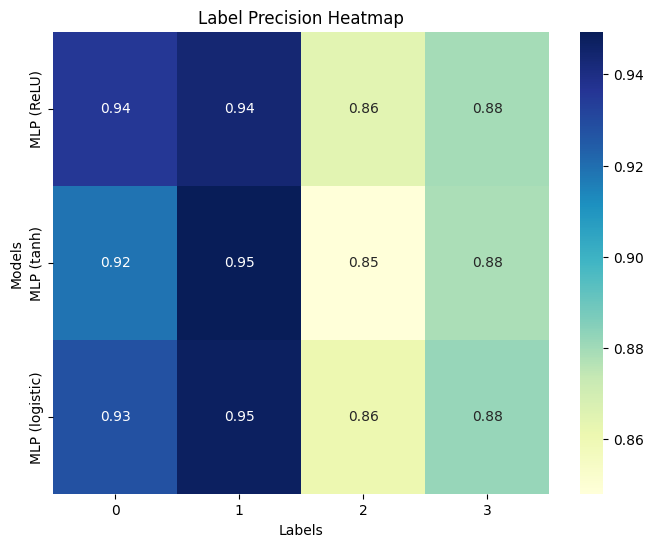

In [82]:
# Data for heatmap
data = [
    mlp_relu_label_precisions,
    mlp_tanh_label_precisions,
    mlp_logistic_label_precisions,
]

heatmap_data = np.array(data)
model_names = ['MLP (ReLU)', 'MLP (tanh)', 'MLP (logistic)']

plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    xticklabels=labels,
    yticklabels=model_names,
    cbar=True
)
plt.title("Label Precision Heatmap")
plt.xlabel("Labels")
plt.ylabel("Models")
plt.show()


## Paper Overview
Paper Overview
Paper: Sun, C., Qiu, X., Xu, Y., Huang, X., 2019. How to Fine-Tune BERT for Text Classification? Proceedings of the 57th Annual Meeting of the Association for Computational Linguistics (ACL). Available at: [https://arxiv.org/abs/1905.05583] [Accessed 10 December 2024].

This paper explores how to fine-tune BERT (Bidirectional Encoder Representations from Transformers) for text classification tasks. The authors aim to make the most of BERT's pre-trained capabilities to boost performance across a variety of datasets.
Through extensive experiments, the study compares different fine-tuning methods and pinpoints best practices for tailoring BERT to various text classification challenges. It assesses BERT's effectiveness in sentiment analysis, question classification, and topic classification, offering insights into how to best adapt fine-tuning for each of these areas.
The paper’s main contributions are:
* It lays out a detailed framework for fine-tuning BERT, incorporating further pre-training, multi-task learning, and specific fine-tuning strategies.
* It shows that BERT can achieve top-notch results across several widely-used text classification datasets.
* It dives into various aspects of fine-tuning, like how to select layers, set learning rates, and manage long texts, all of which play a crucial role in performance.
Methodology
The paper introduces several creative approaches to fine-tuning BERT, including:
* Further pre-training which involves using data specific to the target domain to pre-train BERT before moving on to fine-tuning.
* Layer selection where the authors experiment with outputs from different layers of BERT to figure out which ones work best for classification tasks.
* Implementing different learning rates for different layers to improve the training process and address issues like catastrophic forgetting.
* Multi-task learning by leveraging related tasks. These enhance the model's ability to generalise, allowing for shared learning across various classification challenges.

When testing these methods on datasets like AG's News, the findings indicate that BERT's performance can significantly improve through these fine-tuning strategies. The research highlights how important it is to customise approaches to fully harness BERT's potential for different text classification scenarios.

## Paper Code Recreation

In [2]:
# import BERT
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer, TrainingArguments
from sklearn.metrics import roc_auc_score, classification_report
import torch
import numpy as np


In [3]:
# Load the BERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

id2label = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
label2id = {v: k for k, v in id2label.items()}

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=len(id2label), id2label=id2label, label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [5]:
dataset_dict = ds

In [6]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=512)


In [7]:
tokenized_data = ds.map(preprocess_function, batched=True)

In [8]:
class TokenizedDataset:
    def __init__(self, dataset):
        if isinstance(dataset, dict):
            self.dataset = [
                {key: val[i] for key, val in dataset.items()}
                for i in range(len(next(iter(dataset.values()))))
            ]
        else:
            self.dataset = dataset

    def __getitem__(self, idx):
        item = self.dataset[idx]
        return {
            key: torch.tensor(val) if isinstance(val, list) else val
            for key, val in item.items()
        }

    def get_field(self, field_name):
        # Return all values for a specific field (e.g., 'label')
        return [example[field_name] for example in self.dataset]

    def __len__(self):
        return len(self.dataset)


train_dataset = TokenizedDataset(tokenized_data["train"])
test_dataset = TokenizedDataset(tokenized_data["test"])


In [9]:
data_collator =  DataCollatorWithPadding(tokenizer)

In [10]:
import evaluate
# load metrics
accuracy = evaluate.load("accuracy")
auc_score = evaluate.load("roc_auc")

In [11]:
from sklearn.metrics import classification_report

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    
    # Classification report with zero_division=0 to handle undefined precision
    report = classification_report(labels, preds, output_dict=True, zero_division=0)
    
    # Extract per-class F1 scores dynamically
    f1_per_class = {
        f"class_{cls}": np.round(report[str(cls)]["f1-score"], 4)
        for cls in set(labels)  # Dynamically get all unique class labels
    }
    
    return {
        "accuracy": report["accuracy"],
        "f1_per_class": f1_per_class,
        "weighted_f1": np.round(report["weighted avg"]["f1-score"], 4),
    }


In [12]:
lr = 2e-5
batch_size = 8
num_epochs = 10

In [ ]:
from sklearn.model_selection import train_test_split

# Extract labels
labels = tokenized_data['train']['label']

# Split the dataset
train_indices, _ = train_test_split(
    range(len(labels)), 
    test_size=len(labels) - 16,   
    stratify=labels, 
)

test_labels = tokenized_data['test']['label']
test_indices, _ = train_test_split(
    range(len(test_labels)), 
    test_size=len(test_labels) - 16, 
    stratify=test_labels, 
)

# Create small datasets
small_train_dataset = TokenizedDataset(tokenized_data['train'].select(train_indices))
small_test_dataset = TokenizedDataset(tokenized_data['test'].select(test_indices))

In [14]:
print(small_train_dataset.get_field('label'))  # Show the first few keys or items
# print(small_test_dataset['label'])  # Show the first few keys or items

[3, 3, 2, 1, 3, 2, 0, 0, 1, 1, 0, 3, 0, 2, 2, 1]


In [15]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    logging_strategy="steps",
    logging_steps=10,
    disable_tqdm=False,
    save_strategy="epoch",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    logging_dir="./logs",
    load_best_model_at_end=True,
    use_cpu = not torch.cuda.is_available(),
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_test_dataset,  
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

                                              
 10%|█         | 2/20 [00:41<05:19, 17.76s/it]

{'eval_loss': 1.3575342893600464, 'eval_accuracy': 0.25, 'eval_f1_per_class': {'class_0': 0.0, 'class_1': 0.25, 'class_2': 0.375, 'class_3': 0.0}, 'eval_weighted_f1': 0.1562, 'eval_runtime': 6.6725, 'eval_samples_per_second': 2.398, 'eval_steps_per_second': 0.3, 'epoch': 1.0}


                                              
 20%|██        | 4/20 [01:23<05:18, 19.89s/it]

{'eval_loss': 1.3346357345581055, 'eval_accuracy': 0.4375, 'eval_f1_per_class': {'class_0': 0.4, 'class_1': 0.5, 'class_2': 0.6, 'class_3': 0.0}, 'eval_weighted_f1': 0.375, 'eval_runtime': 6.774, 'eval_samples_per_second': 2.362, 'eval_steps_per_second': 0.295, 'epoch': 2.0}


                                              
 30%|███       | 6/20 [02:04<04:48, 20.64s/it]

{'eval_loss': 1.321720838546753, 'eval_accuracy': 0.5, 'eval_f1_per_class': {'class_0': 0.4, 'class_1': 0.6154, 'class_2': 0.6667, 'class_3': 0.0}, 'eval_weighted_f1': 0.4205, 'eval_runtime': 3.5426, 'eval_samples_per_second': 4.517, 'eval_steps_per_second': 0.565, 'epoch': 3.0}


                                              
 40%|████      | 8/20 [02:41<03:41, 18.46s/it]

{'eval_loss': 1.2987985610961914, 'eval_accuracy': 0.5, 'eval_f1_per_class': {'class_0': 0.4, 'class_1': 0.7273, 'class_2': 0.6667, 'class_3': 0.0}, 'eval_weighted_f1': 0.4485, 'eval_runtime': 6.1373, 'eval_samples_per_second': 2.607, 'eval_steps_per_second': 0.326, 'epoch': 4.0}


 50%|█████     | 10/20 [03:09<02:53, 17.36s/it]

{'loss': 1.2737, 'grad_norm': 6.669741153717041, 'learning_rate': 1e-05, 'epoch': 5.0}


                                               
 50%|█████     | 10/20 [03:13<02:53, 17.36s/it]

{'eval_loss': 1.2687729597091675, 'eval_accuracy': 0.4375, 'eval_f1_per_class': {'class_0': 0.4, 'class_1': 0.6, 'class_2': 0.6667, 'class_3': 0.0}, 'eval_weighted_f1': 0.4167, 'eval_runtime': 4.395, 'eval_samples_per_second': 3.64, 'eval_steps_per_second': 0.455, 'epoch': 5.0}


                                               
 60%|██████    | 12/20 [03:44<02:08, 16.01s/it]

{'eval_loss': 1.2454856634140015, 'eval_accuracy': 0.5625, 'eval_f1_per_class': {'class_0': 0.8571, 'class_1': 0.6, 'class_2': 0.6667, 'class_3': 0.0}, 'eval_weighted_f1': 0.531, 'eval_runtime': 4.3698, 'eval_samples_per_second': 3.661, 'eval_steps_per_second': 0.458, 'epoch': 6.0}


                                               
 70%|███████   | 14/20 [04:13<01:29, 14.97s/it]

{'eval_loss': 1.2366626262664795, 'eval_accuracy': 0.5625, 'eval_f1_per_class': {'class_0': 0.8571, 'class_1': 0.6, 'class_2': 0.6667, 'class_3': 0.0}, 'eval_weighted_f1': 0.531, 'eval_runtime': 5.2835, 'eval_samples_per_second': 3.028, 'eval_steps_per_second': 0.379, 'epoch': 7.0}


                                               
 80%|████████  | 16/20 [04:43<00:59, 15.00s/it]

{'eval_loss': 1.2294464111328125, 'eval_accuracy': 0.625, 'eval_f1_per_class': {'class_0': 1.0, 'class_1': 0.6, 'class_2': 0.6667, 'class_3': 0.0}, 'eval_weighted_f1': 0.5667, 'eval_runtime': 3.994, 'eval_samples_per_second': 4.006, 'eval_steps_per_second': 0.501, 'epoch': 8.0}


                                               
 90%|█████████ | 18/20 [05:15<00:29, 14.89s/it]

{'eval_loss': 1.2256145477294922, 'eval_accuracy': 0.625, 'eval_f1_per_class': {'class_0': 1.0, 'class_1': 0.6, 'class_2': 0.6667, 'class_3': 0.0}, 'eval_weighted_f1': 0.5667, 'eval_runtime': 4.8364, 'eval_samples_per_second': 3.308, 'eval_steps_per_second': 0.414, 'epoch': 9.0}


100%|██████████| 20/20 [05:38<00:00, 13.86s/it]

{'loss': 1.0118, 'grad_norm': 8.343769073486328, 'learning_rate': 0.0, 'epoch': 10.0}


                                               
100%|██████████| 20/20 [05:43<00:00, 13.86s/it]

{'eval_loss': 1.224010944366455, 'eval_accuracy': 0.625, 'eval_f1_per_class': {'class_0': 1.0, 'class_1': 0.6, 'class_2': 0.6667, 'class_3': 0.0}, 'eval_weighted_f1': 0.5667, 'eval_runtime': 4.0087, 'eval_samples_per_second': 3.991, 'eval_steps_per_second': 0.499, 'epoch': 10.0}


100%|██████████| 20/20 [05:45<00:00, 17.27s/it]

{'train_runtime': 345.3513, 'train_samples_per_second': 0.463, 'train_steps_per_second': 0.058, 'train_loss': 1.142726755142212, 'epoch': 10.0}


TrainOutput(global_step=20, training_loss=1.142726755142212, metrics={'train_runtime': 345.3513, 'train_samples_per_second': 0.463, 'train_steps_per_second': 0.058, 'total_flos': 28416504250368.0, 'train_loss': 1.142726755142212, 'epoch': 10.0})

In [16]:
results = trainer.evaluate()

100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


In [23]:
print(results)

{'eval_loss': 1.224010944366455, 'eval_accuracy': 0.625, 'eval_f1_per_class': {'class_0': 1.0, 'class_1': 0.6, 'class_2': 0.6667, 'class_3': 0.0}, 'eval_weighted_f1': 0.5667, 'eval_runtime': 4.5013, 'eval_samples_per_second': 3.555, 'eval_steps_per_second': 0.444, 'epoch': 10.0}


In [17]:
# implement for only top layer
from transformers import BertModel, BertPreTrainedModel, BertConfig
import torch.nn as nn

class TopLayerBertForSequenceClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.config.num_labels)

        self.init_weights()

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, inputs_embeds=None, labels=None):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            return_dict=True,
        )

        top_layer_output = outputs.last_hidden_state

        # use clas token's representation for classification
        cls_output = top_layer_output[:, 0, :] # [batch_size, hidden_size]

        logits = self.classifier(cls_output)

        # calculate loss
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return (loss, logits) if loss is not None else logits

In [18]:
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=len(id2label))

model_top_layer = TopLayerBertForSequenceClassification(config)

In [19]:
training_args_top_layer = TrainingArguments(
    output_dir="./results-top-layer",
    evaluation_strategy="epoch",
    logging_strategy="steps",
    logging_steps=10,
    disable_tqdm=False,
    save_strategy="epoch",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    logging_dir="./logs",
    load_best_model_at_end=True,
    use_cpu = not torch.cuda.is_available(),
)

trainer_top_layer = Trainer(
    model=model_top_layer,
    args=training_args_top_layer,
    train_dataset=small_train_dataset,
    eval_dataset=small_test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

c:\Users\User\Documents\CMM307-PRINCESS-UKANWA\cmmvenv\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [20]:
trainer_top_layer.train()

 10%|█         | 2/20 [00:25<03:15, 10.88s/it]

{'eval_loss': 2.630808115005493, 'eval_accuracy': 0.25, 'eval_f1_per_class': {'class_0': 0.4, 'class_1': 0.0, 'class_2': 0.0, 'class_3': 0.0}, 'eval_weighted_f1': 0.1, 'eval_runtime': 3.9505, 'eval_samples_per_second': 4.05, 'eval_steps_per_second': 0.506, 'epoch': 1.0}


 20%|██        | 4/20 [00:54<03:28, 13.06s/it]

{'eval_loss': 1.6038190126419067, 'eval_accuracy': 0.25, 'eval_f1_per_class': {'class_0': 0.0, 'class_1': 0.4, 'class_2': 0.0, 'class_3': 0.0}, 'eval_weighted_f1': 0.1, 'eval_runtime': 5.0246, 'eval_samples_per_second': 3.184, 'eval_steps_per_second': 0.398, 'epoch': 2.0}


 30%|███       | 6/20 [01:34<03:49, 16.40s/it]

{'eval_loss': 1.5799089670181274, 'eval_accuracy': 0.25, 'eval_f1_per_class': {'class_0': 0.0, 'class_1': 0.0, 'class_2': 0.4, 'class_3': 0.0}, 'eval_weighted_f1': 0.1, 'eval_runtime': 7.243, 'eval_samples_per_second': 2.209, 'eval_steps_per_second': 0.276, 'epoch': 3.0}


 40%|████      | 8/20 [02:30<04:18, 21.56s/it]

{'eval_loss': 1.8150584697723389, 'eval_accuracy': 0.25, 'eval_f1_per_class': {'class_0': 0.0, 'class_1': 0.0, 'class_2': 0.0, 'class_3': 0.4}, 'eval_weighted_f1': 0.1, 'eval_runtime': 9.3487, 'eval_samples_per_second': 1.711, 'eval_steps_per_second': 0.214, 'epoch': 4.0}


 50%|█████     | 10/20 [03:14<03:57, 23.71s/it]

{'loss': 1.9443, 'grad_norm': 21.51105499267578, 'learning_rate': 1e-05, 'epoch': 5.0}



 50%|█████     | 10/20 [03:23<03:57, 23.71s/it]

{'eval_loss': 1.570296049118042, 'eval_accuracy': 0.25, 'eval_f1_per_class': {'class_0': 0.0, 'class_1': 0.0, 'class_2': 0.0, 'class_3': 0.4}, 'eval_weighted_f1': 0.1, 'eval_runtime': 8.8197, 'eval_samples_per_second': 1.814, 'eval_steps_per_second': 0.227, 'epoch': 5.0}


 60%|██████    | 12/20 [04:18<03:20, 25.07s/it]

{'eval_loss': 1.4000468254089355, 'eval_accuracy': 0.25, 'eval_f1_per_class': {'class_0': 0.4, 'class_1': 0.0, 'class_2': 0.0, 'class_3': 0.0}, 'eval_weighted_f1': 0.1, 'eval_runtime': 8.6544, 'eval_samples_per_second': 1.849, 'eval_steps_per_second': 0.231, 'epoch': 6.0}


 70%|███████   | 14/20 [05:06<02:26, 24.44s/it]

{'eval_loss': 1.412597417831421, 'eval_accuracy': 0.4375, 'eval_f1_per_class': {'class_0': 0.6667, 'class_1': 0.5333, 'class_2': 0.0, 'class_3': 0.0}, 'eval_weighted_f1': 0.3, 'eval_runtime': 8.5484, 'eval_samples_per_second': 1.872, 'eval_steps_per_second': 0.234, 'epoch': 7.0}


 80%|████████  | 16/20 [06:03<01:44, 26.06s/it]

{'eval_loss': 1.4552253484725952, 'eval_accuracy': 0.25, 'eval_f1_per_class': {'class_0': 0.0, 'class_1': 0.4211, 'class_2': 0.0, 'class_3': 0.0}, 'eval_weighted_f1': 0.1053, 'eval_runtime': 8.6461, 'eval_samples_per_second': 1.851, 'eval_steps_per_second': 0.231, 'epoch': 8.0}


 90%|█████████ | 18/20 [06:56<00:51, 25.64s/it]

{'eval_loss': 1.4565331935882568, 'eval_accuracy': 0.25, 'eval_f1_per_class': {'class_0': 0.0, 'class_1': 0.4, 'class_2': 0.0, 'class_3': 0.0}, 'eval_weighted_f1': 0.1, 'eval_runtime': 8.6915, 'eval_samples_per_second': 1.841, 'eval_steps_per_second': 0.23, 'epoch': 9.0}


100%|██████████| 20/20 [07:36<00:00, 24.27s/it]

{'loss': 1.3857, 'grad_norm': 15.834243774414062, 'learning_rate': 0.0, 'epoch': 10.0}



100%|██████████| 20/20 [07:47<00:00, 24.27s/it]

{'eval_loss': 1.454874038696289, 'eval_accuracy': 0.25, 'eval_f1_per_class': {'class_0': 0.0, 'class_1': 0.4, 'class_2': 0.0, 'class_3': 0.0}, 'eval_weighted_f1': 0.1, 'eval_runtime': 8.939, 'eval_samples_per_second': 1.79, 'eval_steps_per_second': 0.224, 'epoch': 10.0}


100%|██████████| 20/20 [07:50<00:00, 23.53s/it]

{'train_runtime': 470.5159, 'train_samples_per_second': 0.34, 'train_steps_per_second': 0.043, 'train_loss': 1.664987564086914, 'epoch': 10.0}


TrainOutput(global_step=20, training_loss=1.664987564086914, metrics={'train_runtime': 470.5159, 'train_samples_per_second': 0.34, 'train_steps_per_second': 0.043, 'total_flos': 28416504250368.0, 'train_loss': 1.664987564086914, 'epoch': 10.0})

In [21]:
results_top_layer = trainer_top_layer.evaluate()

100%|██████████| 2/2 [00:04<00:00,  2.21s/it]


In [22]:
print(results_top_layer)

{'eval_loss': 1.4000468254089355, 'eval_accuracy': 0.25, 'eval_f1_per_class': {'class_0': 0.4, 'class_1': 0.0, 'class_2': 0.0, 'class_3': 0.0}, 'eval_weighted_f1': 0.1, 'eval_runtime': 8.7918, 'eval_samples_per_second': 1.82, 'eval_steps_per_second': 0.227, 'epoch': 10.0}


## Paper Evaluation
The results from using only the top layer of BERT for text classification reveal that this approach does not enhance classification accuracy but rather reduces it. The results indicates that relying solely on the top layer can limit the model's effectiveness, as evidenced by the particularly poor performance in Class 2  and the low overall accuracy of 25% as compared to the 62.5% outputted by the full layer implementation of BERT. The overall results  convey that the all-layers method improves accuracy and F1 scores across classes.

However, the paper discusses several fine-tuning techniques that were not employed in this implementation, such as further pre-training, multi-task learning, and adjustments to learning rates. Exploring these additional strategies could potentially enhance the model's performance, making it more efficient in classifying texts across all categories. Therefore, integrating these techniques may lead to better outcomes and a more robust classification model.

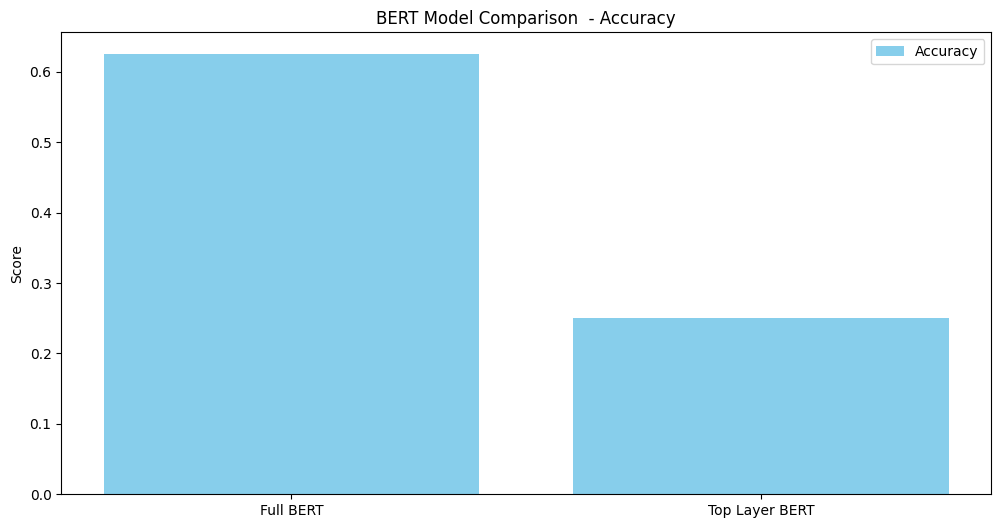

In [28]:
# plot the results

# get results for each BERT variant
bert_results = {
    "Full BERT": results,
    "Top Layer BERT": results_top_layer,
}

# extract the accuracy and weighted F1 scores
accuracies = [result["eval_accuracy"] for result in bert_results.values()]
# weighted_f1_scores = [result["eval_weighted_f1"] for result in bert_results.values()]

# plot the results
plt.figure(figsize=(12, 6))

plt.bar(bert_results.keys(), accuracies, color='skyblue', label='Accuracy')
# plt.bar(bert_results.keys(), weighted_f1_scores, color='salmon', label='Weighted F1 Score')

plt.ylabel("Score")
plt.title("BERT Model Comparison  - Accuracy")
plt.legend()

plt.show()

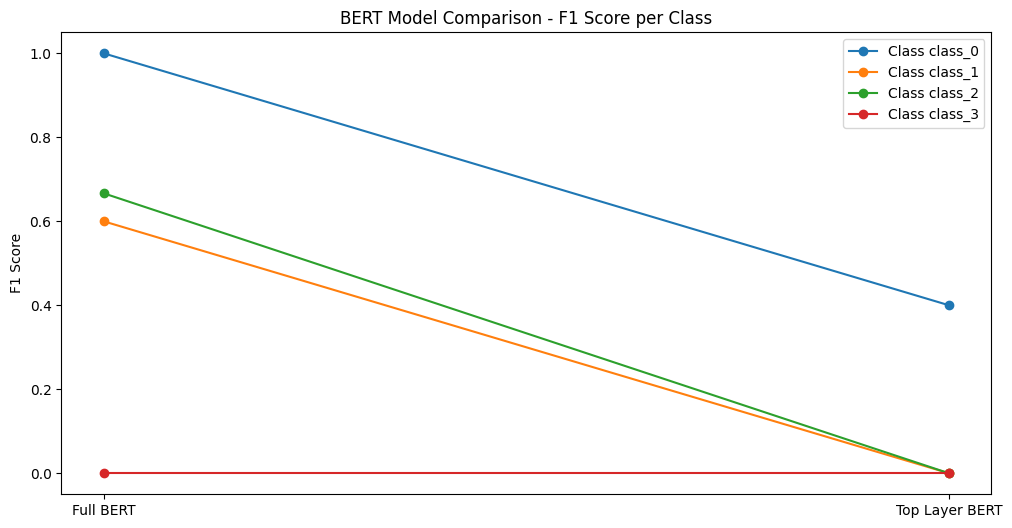

In [30]:
# plot weighted f1 score

# get f1 score for each class in each BERT variant
f1_per_class = {
    model_name: result["eval_f1_per_class"]
    for model_name, result in bert_results.items()
}

# extract the f1 scores for each class

f1_scores = {
    cls: [f1[cls] for f1 in f1_per_class.values()]
    for cls in f1_per_class["Full BERT"].keys()
}

# plot the results
plt.figure(figsize=(12, 6))

for cls, scores in f1_scores.items():
    plt.plot(bert_results.keys(), scores, marker='o', label=f'Class {cls}')

plt.ylabel("F1 Score")
plt.title("BERT Model Comparison - F1 Score per Class")
plt.legend()

plt.show()